In [1]:
import re
from matplotlib import pyplot as plt
import pandas as pd

In [2]:
with open("traceroute1649317892.txt") as f:
    buf = f.read()

In [3]:
parts = [p for p in  buf.split("START") if p not in [""]]

In [4]:
def dump_to_tuple(dump):
    
    """
    Converts a raw traceroute data-dump into a summarized tuple.
    """
    
    # timestamp
    lines = [l for l in dump.split("\n") if l not in [ "" ] ]
    timestamp = int( lines[0])
    
    # first line (beside the timestamp)
    l1 = lines[1]
    # last line 
    last = lines[-1]
    
    try:
        ip1 = re.match(".*\((.*)\).*", l1).group(1)
        ip2 = re.match(".*\((.*)\).*", last).group(1)
    except:
        pass
    
    # check if target was reached 
    reached = ip1==ip2!=None
    
    # number of hops
    hops = int(last [:4] )
    
    # target latency (ms)
    try:    
        times = re.findall("\d+.\d+ ms", last)
        times = [float(t.replace("ms", "")) for t in times ]
        latency = sum(times)/len(times)
    except:
        latency = None
    
    return (timestamp, hops, reached, latency)

# Convert dumps to dataframe

In [5]:
tuples = [dump_to_tuple(p) for p in parts]

In [6]:
df = pd.DataFrame(tuples, columns=["timestamp", "hops", "reached", "latency"])

## Re-format timestamp

In [7]:
df["timestamp"] = pd.to_datetime(df.timestamp, unit="s")

In [8]:
df = df.set_index("timestamp")

## Group readings by hour (get mean)

In [9]:
# TODO: group by hour once you have enough data
# group the same hour from different days!
df = df.resample("60min").aggregate("mean")
# variance could be of interest as well (higher variance => network is unstable):
# df = df.resample("1min").aggregate("var")

In [10]:
# df

In [11]:
df["dropped"] = 1 - df.reached

In [12]:
df

,hops,reached,latency,dropped
timestamp,,,,
2022-04-07 08:00:00,13.142857,1.0,0.972357,0.0
2022-04-07 09:00:00,13.250000,1.0,1.046972,0.0
2022-04-07 10:00:00,13.666667,1.0,0.640069,0.0
2022-04-07 11:00:00,13.727273,1.0,0.741530,0.0
2022-04-07 12:00:00,14.083333,1.0,0.716292,0.0
...,...,...,...,...
2022-04-14 11:00:00,12.833333,1.0,0.610708,0.0
2022-04-14 12:00:00,12.750000,1.0,0.602347,0.0
2022-04-14 13:00:00,13.916667,1.0,0.618611,0.0


<AxesSubplot:xlabel='timestamp', ylabel='latency (ms)'>

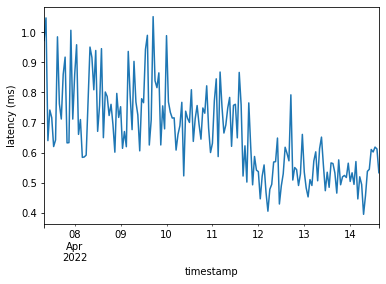

In [13]:
plt.ylabel("latency (ms)")
df.latency.plot()

<AxesSubplot:xlabel='timestamp', ylabel='drop-rate'>

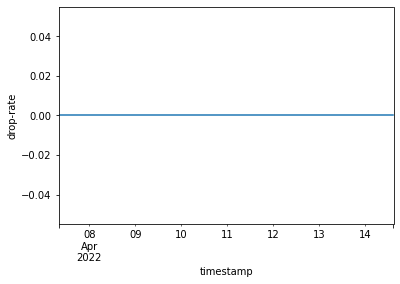

In [14]:
plt.ylabel("drop-rate")
df.dropped.plot()

<AxesSubplot:xlabel='timestamp', ylabel='hops'>

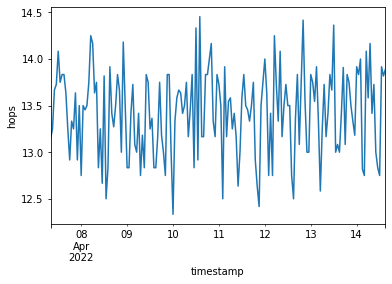

In [15]:
plt.ylabel("hops")
df.hops.plot()

In [16]:
df["hour"] = df.index.hour

In [17]:
df.head()

,hops,reached,latency,dropped,hour
timestamp,,,,,
2022-04-07 08:00:00,13.142857,1.0,0.972357,0.0,8
2022-04-07 09:00:00,13.250000,1.0,1.046972,0.0,9
2022-04-07 10:00:00,13.666667,1.0,0.640069,0.0,10
2022-04-07 11:00:00,13.727273,1.0,0.741530,0.0,11
2022-04-07 12:00:00,14.083333,1.0,0.716292,0.0,12


In [18]:
df1 = df.groupby("hour").mean().latency.to_frame()

In [19]:
df1 =  df1.rename(columns={"latency":"mean_latency"})

In [20]:
df1["std_err"] = df.groupby("hour").std().latency

In [21]:
df1 = df1.sort_values(ascending=False, by="mean_latency")

In [22]:
df1

,mean_latency,std_err
hour,,
14,0.734629,0.169578
17,0.731917,0.179329
8,0.730703,0.179009
19,0.721593,0.148469
9,0.719397,0.188321
22,0.696383,0.173753
0,0.686992,0.185397
11,0.680655,0.167985
15,0.678331,0.144135


<AxesSubplot:xlabel='hour'>

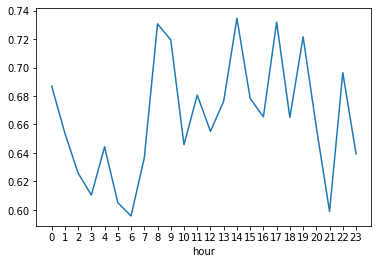

In [23]:
plt.xticks(list(range(24)))
df.groupby("hour").mean().latency.plot()

In [24]:
# plt.xticks(list(range(24)))
# df.groupby("hour").var().latency.plot()

<AxesSubplot:xlabel='hour'>

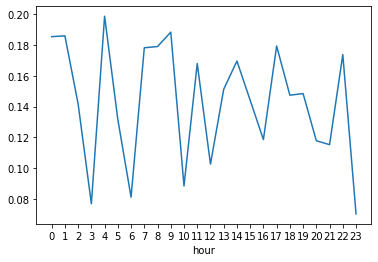

In [25]:
plt.xticks(list(range(24)))
df.groupby("hour").std().latency.plot()